# IMPORT LIBRARIES

In [1]:
import sys
sys.path.append("../")
import config

import os
import random
import math
import time
import numpy as np
import pandas as pd
import torch
import scipy.stats
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances, pairwise

# CHANNELS INFO
channels = config.channels
input_channels = config.weather_channels+config.sf_channels
static_channels = config.static_channels

# TIME SERIES INFO
window = config.window

# TRAIN INFO
device = torch.device("cuda")
code_dim = 256
n_clusters = 20
epochs = 30
batch_size = 200
learning_rate = 0.005
alpha = 1.0

# MODEL INFO
recon_weight = 1.0
static_weight = 1.0
triplet_weight = 0
sum_weight = recon_weight+static_weight+triplet_weight
architecture = "ATT_SF"

# MODEL NAME
model_name = "Unified_Triplet"
pretrain = None

print("{} Hyperparameters".format(model_name))
print("Channels : {}".format(channels))
print("Input Channels : {}".format(input_channels))
print("Static Channels : {}".format(static_channels))
print("Code dim : {}".format(code_dim))
print("Epochs : {}".format(epochs))
print("Batch Size : {}".format(batch_size))
print("Learning rate : {}".format(learning_rate))
print("Reconstruction Weight : {}".format(recon_weight))
print("Static Weight : {}".format(static_weight))
print("Triplet Weight : {}".format(triplet_weight))
print("Pretrain : {}".format(pretrain))

if not os.path.exists(os.path.join(config.MODEL_DIR)):
    os.makedirs(os.path.join(config.MODEL_DIR))
if not os.path.exists(os.path.join(config.RESULT_DIR)):
    os.makedirs(os.path.join(config.RESULT_DIR))

Unified_Triplet Hyperparameters
Channels : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Input Channels : [27, 28, 29, 30, 31, 32]
Static Channels : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Code dim : 256
Epochs : 30
Batch Size : 200
Learning rate : 0.005
Reconstruction Weight : 1.0
Static Weight : 1.0
Triplet Weight : 0
Pretrain : None


# LOAD DATA

In [2]:
train_data = np.load(os.path.join(config.NUMPY_DIR, "train_data.npy"))
validation_data = np.load(os.path.join(config.NUMPY_DIR, "validation_data.npy"))
test_data = np.load(os.path.join(config.NUMPY_DIR, "test_data.npy"))
print("Train Data:{}\tValidation Data:{}\tTest Data:{}".format(train_data.shape, validation_data.shape, test_data.shape))

feature_names = np.load(os.path.join(config.DATA_DIR, "RAW_DATA", "feature_names.npy"), allow_pickle=True)
print("Static features:{}".format(feature_names[config.static_channels]))
print("Weather features:{}".format(feature_names[config.weather_channels]))
print("SF features:{}".format(feature_names[config.sf_channels]))

embeddings = np.load(os.path.join(config.RESULT_DIR, "{}_Embeddings.npy".format(model_name)))
print(embeddings.shape)

Train Data:(531, 39, 365, 33)	Validation Data:(531, 19, 365, 33)	Test Data:(531, 9, 365, 33)
Static features:['p_mean' 'pet_mean' 'p_seasonality' 'frac_snow' 'aridity'
 'high_prec_freq' 'high_prec_dur' 'low_prec_freq' 'low_prec_dur'
 'carbonate_rocks_frac' 'geol_permeability' 'soil_depth_pelletier'
 'soil_depth_statsgo' 'soil_porosity' 'soil_conductivity'
 'max_water_content' 'sand_frac' 'silt_frac' 'clay_frac' 'elev_mean'
 'slope_mean' 'area_gages2' 'frac_forest' 'lai_max' 'lai_diff' 'gvf_max'
 'gvf_diff']
Weather features:['PRCP(mm/day)' 'SRAD(W/m2)' 'Tmax(C)' 'Tmin(C)' 'Vp(Pa)']
SF features:['SF']
(531, 39, 256)


# COSINE SIMILARITY

## COMPUTE SIMILARITY

In [3]:
static_embeddings = train_data[:,0,0,static_channels]
print(static_embeddings.shape)
static_sim = pairwise.cosine_similarity(static_embeddings)

deep_embeddings = np.nanmean(embeddings, axis=1)
print(deep_embeddings.shape)
deep_sim = pairwise.cosine_similarity(deep_embeddings)

(531, 27)
(531, 256)


## SIMILARITY DISTRIBUTION

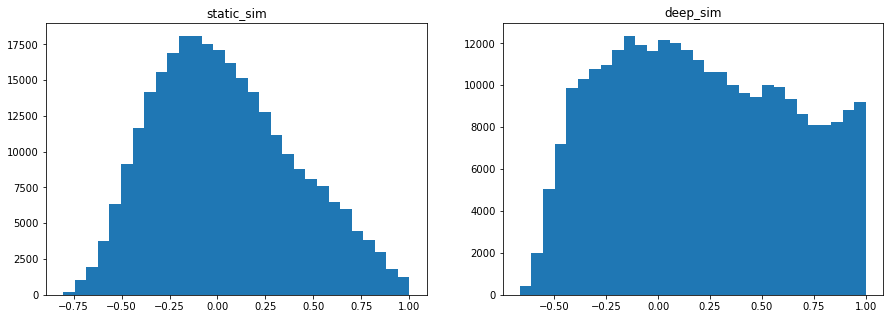

In [4]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.hist(static_sim.flatten(), bins=30)
ax.set_title("static_sim")
ax = fig.add_subplot(1,2,2)
ax.hist(deep_sim.flatten(), bins=30)
ax.set_title("deep_sim")
plt.show()

## VISUALIZE SIMILARITY

In [5]:
# fig = plt.figure(figsize=(2*(static_sim.shape[0]//20), static_sim.shape[0]//20))
# fontsize = 20

# ax = fig.add_subplot(1,2,1)
# ax.set_xticks(range(static_sim.shape[0]))
# ax.set_xticklabels(np.array(range(static_sim.shape[0])), fontsize=fontsize, rotation=90)
# ax.set_yticks(range(static_sim.shape[0]))
# ax.set_yticklabels(np.array(range(static_sim.shape[0])), fontsize=fontsize)
# ax.set_title("static_sim", fontsize=fontsize)
# im = ax.imshow(static_sim)
# plt.colorbar(im)

# ax = fig.add_subplot(1,2,2)
# ax.set_xticks(range(deep_sim.shape[0]))
# ax.set_xticklabels(np.array(range(deep_sim.shape[0])), fontsize=fontsize, rotation=90)
# ax.set_yticks(range(deep_sim.shape[0]))
# ax.set_yticklabels(np.array(range(deep_sim.shape[0])), fontsize=fontsize)
# ax.set_title("deep_sim", fontsize=fontsize)
# im = ax.imshow(deep_sim)
# plt.colorbar(im)
# plt.show()

## COMPUTE PEARSON CORRELATION

Min:-0.01096631071361488	Basin:158
Max:0.8556231582994437	Basin:434


/home/kumarv/ghosh128/anaconda3/envs/main/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/kumarv/ghosh128/anaconda3/envs/main/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


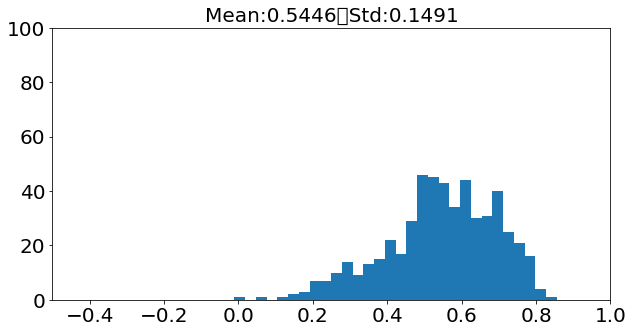

In [6]:
score = np.zeros(static_sim.shape[0])
for basin in range(static_sim.shape[0]):
    basin_static_sim = static_sim[basin]
    basin_deep_sim = deep_sim[basin]
    score[basin] = scipy.stats.pearsonr(basin_static_sim, basin_deep_sim)[0]

print("Min:{}\tBasin:{}".format(np.min(score), np.argmin(score)))
print("Max:{}\tBasin:{}".format(np.max(score), np.argmax(score)))
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.hist(score, bins=30)
ax.set_xlim(-0.5,1)
ax.set_ylim(0,100)
ax.tick_params(axis='both', labelsize=20)
ax.set_title("Mean:{:.4f}\tStd:{:.4f}".format(np.mean(score), np.std(score)), fontsize=20)
plt.show()

# width = 0.4
# fig = plt.figure(figsize=(static_sim.shape[0]//20,5))
# ax = fig.add_subplot(1,1,1)
# ax.bar(np.array(range(static_sim.shape[0])), score, width=width)

## COMPUTE SIMILARITY

158


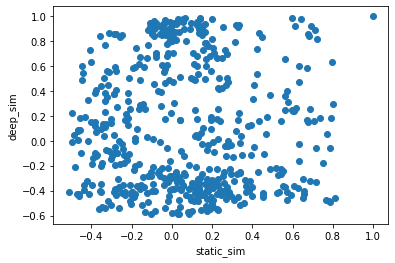

434


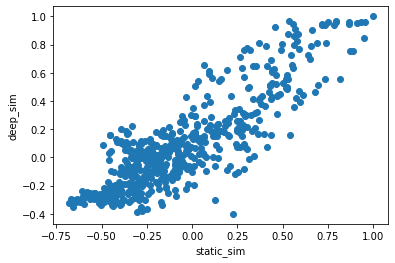

In [7]:
basin = np.argmin(score)
basin_static_sim = static_sim[basin]
basin_deep_sim = deep_sim[basin]
print(basin)
plt.scatter(basin_static_sim, basin_deep_sim)
plt.xlabel("static_sim")
plt.ylabel("deep_sim")
plt.show()

basin = np.argmax(score)
basin_static_sim = static_sim[basin]
basin_deep_sim = deep_sim[basin]
print(basin)
plt.scatter(basin_static_sim, basin_deep_sim)
plt.xlabel("static_sim")
plt.ylabel("deep_sim")
plt.show()

# EUCLIDEAN DISTANCE

## COMPUTE DISTANCE

In [8]:
static_embeddings = train_data[:,0,0,static_channels]
print(static_embeddings.shape)
static_dist = pairwise_distances(static_embeddings)

deep_embeddings = np.nanmean(embeddings, axis=1)
print(deep_embeddings.shape)
deep_dist = pairwise_distances(deep_embeddings)

(531, 27)
(531, 256)


## DISTANCE DISTRIBUTION

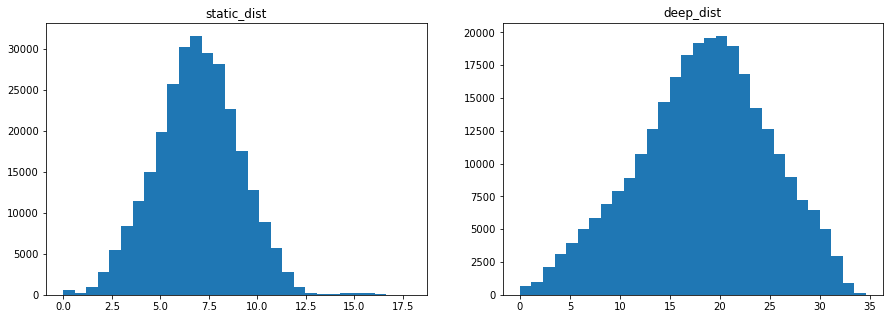

In [9]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.hist(static_dist.flatten(), bins=30)
ax.set_title("static_dist")
ax = fig.add_subplot(1,2,2)
ax.hist(deep_dist.flatten(), bins=30)
ax.set_title("deep_dist")
plt.show()

## VISUALIZE DISTANCE

In [10]:
# fig = plt.figure(figsize=(2*(static_dist.shape[0]//20), static_dist.shape[0]//20))
# fontsize = 20

# ax = fig.add_subplot(1,2,1)
# ax.set_xticks(range(static_dist.shape[0]))
# ax.set_xticklabels(np.array(range(static_dist.shape[0])), fontsize=fontsize, rotation=90)
# ax.set_yticks(range(static_dist.shape[0]))
# ax.set_yticklabels(np.array(range(static_dist.shape[0])), fontsize=fontsize)
# ax.set_title("static_dist", fontsize=fontsize)
# im = ax.imshow(static_dist)
# plt.colorbar(im)

# ax = fig.add_subplot(1,2,2)
# ax.set_xticks(range(deep_dist.shape[0]))
# ax.set_xticklabels(np.array(range(deep_dist.shape[0])), fontsize=fontsize, rotation=90)
# ax.set_yticks(range(deep_dist.shape[0]))
# ax.set_yticklabels(np.array(range(deep_dist.shape[0])), fontsize=fontsize)
# ax.set_title("deep_dist", fontsize=fontsize)
# im = ax.imshow(deep_dist)
# plt.colorbar(im)
# plt.show()

## COMPUTE PEARSON CORRELATION

Min:0.14504799285784029	Basin:297
Max:0.7856461220480515	Basin:434


/home/kumarv/ghosh128/anaconda3/envs/main/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/kumarv/ghosh128/anaconda3/envs/main/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


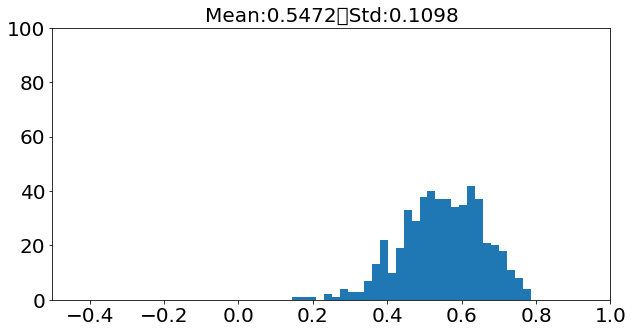

In [11]:
score = np.zeros(static_dist.shape[0])
for basin in range(static_dist.shape[0]):
    basin_static_dist = static_dist[basin]
    basin_deep_dist = deep_dist[basin]
    score[basin] = scipy.stats.pearsonr(basin_static_dist, basin_deep_dist)[0]

print("Min:{}\tBasin:{}".format(np.min(score), np.argmin(score)))
print("Max:{}\tBasin:{}".format(np.max(score), np.argmax(score)))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.hist(score, bins=30)
ax.set_xlim(-0.5,1)
ax.set_ylim(0,100)
ax.tick_params(axis='both', labelsize=20)
ax.set_title("Mean:{:.4f}\tStd:{:.4f}".format(np.mean(score), np.std(score)), fontsize=20)
plt.show()

# width = 0.4
# fig = plt.figure(figsize=(static_dist.shape[0]//20,5))
# ax = fig.add_subplot(1,1,1)
# ax.bar(np.array(range(static_dist.shape[0])), score, width=width)

## COMPARE DISTANCE

297


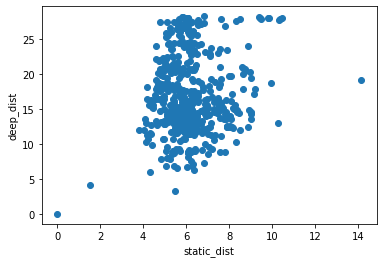

434


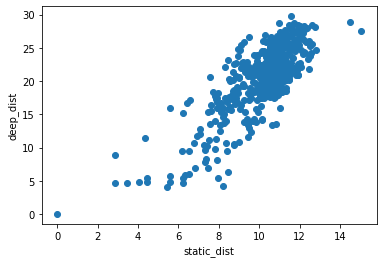

In [12]:
basin = np.argmin(score)
basin_static_dist = static_dist[basin]
basin_deep_dist = deep_dist[basin]
print(basin)
plt.scatter(basin_static_dist, basin_deep_dist)
plt.xlabel("static_dist")
plt.ylabel("deep_dist")
plt.show()

basin = np.argmax(score)
basin_static_dist = static_dist[basin]
basin_deep_dist = deep_dist[basin]
print(basin)
plt.scatter(basin_static_dist, basin_deep_dist)
plt.xlabel("static_dist")
plt.ylabel("deep_dist")
plt.show()